In [1]:
import pandas as pd
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

Using TensorFlow backend.


# Setup

In [2]:
df = pd.read_csv("fake_job_postings.csv",index_col='job_id')

Because we've identified the False Negative to be the errors with the highest cost and because we'd rather use a ROC_AUC score (as well as the ROC curve which has the benefit to help us fine tune the most efficient model), we've decided to swap the values in the 'fraudulent' column. This means the model will now predict if a job post is legitimate and it will allow us to minimise the False positive (when an offer is flagged as legit by the model but actually is of fraudulent nature):

In [3]:
df['fraudulent'].replace([0,1], [1,0], inplace=True)

## Addressing the missing information

We have decided to address the missing information in the different columns by replacing the lack of information by `NA`. Instead of using the 'Other' or 'Unspecified' values available in certain columns, this will allow us to quickly spot when the information was not provided:
01. title:               No missing data
02. location:            NA
03. department:          NA
04. salary_range:        NA
05. company_profile:     NA
06. description:         NA
07. requirements:        NA
08. benefits:            NA
09. telecommuting:       No missing data
10. has_company_logo:    No missing data
11. has_questions:       No missing data
12. employment_type:     NA
13. required_experience: NA
14. required_education:  NA
15. industry:            NA
16. function:            NA
17. fraudulent:          No missing data

In [4]:
for column in df.columns:
    df[column].fillna('NA', inplace=True)

 Some job offers have contact details or external url. Could this be linked to fraudulent activity? Could this improve our model's performance?

In [5]:
# turn into a function: use dict (columnName:textToSearch, list(dictinput.keys())[0]:list(dictinput.values())[0])
df = df.assign(hasEMAIL=0, hasPHONE=0, hasURL=0)
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        if df[column][i].find('#URL_')!=-1:
            df['hasURL'][i] = 1
        elif df[column][i].find('#PHONE_')!=-1:
            df['hasPHONE'][i] = 1
        elif df[column][i].find('#EMAIL_')!=-1:
            df['hasEMAIL'][i] = 1

<ipython-input-5-aa442dc4e235>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hasURL'][i] = 1
<ipython-input-5-aa442dc4e235>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hasPHONE'][i] = 1
<ipython-input-5-aa442dc4e235>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hasEMAIL'][i] = 1


Let's see if any clear pattern can already be identified:

In [ ]:
[df[column].value_counts() for column in df.columns]

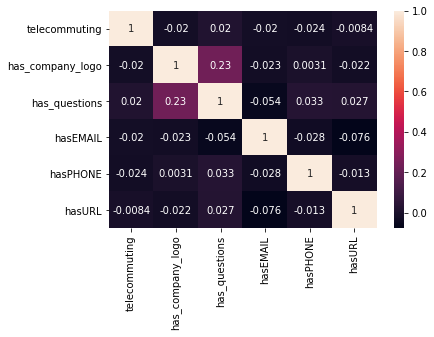

In [7]:
sns.heatmap(df.drop(columns=['fraudulent']).corr(), annot=True);

No multicollinearity issues with those binary variables

## Text cleaning and pre-processing

In [8]:
for column in df.columns[4:8]:
    for i in range(1,len(df[column])):
        df[column][i] = re.sub(r'([A-Z][a-z])', r' \1', df[column][i])

<ipython-input-8-557ad1857d1b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column][i] = re.sub(r'([A-Z][a-z])', r' \1', df[column][i])


# Train Test Split

In [9]:
labels = df['fraudulent']
features = df.drop(columns=['fraudulent'])

In [10]:
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                    labels,
                                                    random_state=666)

features_train, features_validate, labels_train, labels_validate = train_test_split(features_train,
                                                           labels_train,
                                                           random_state=666
                                                           )

# Initialising K-Folds
# kfold = KFold(n_splits=5,
#               random_state=666,
#               shuffle=True
#              )

# TF-IDF computation

In [24]:
vect_comp = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english')
vect_desc = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english')
vect_req = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english')
vect_ben = TfidfVectorizer(input='content', strip_accents='unicode', token_pattern=r'\w+', analyzer='word', stop_words='english')

In [25]:
features_train_vectorized_c = vect_comp.fit_transform([document for document in features_train['company_profile']])
features_validate_vectorized_c = vect_comp.transform([document for document in features_validate['company_profile']])
features_test_vectorized_c = vect_comp.transform([document for document in features_test['company_profile']])

features_train_vectorized_cd = vect_desc.fit_transform([document for document in features_train['description']])
features_validate_vectorized_cd = vect_desc.transform([document for document in features_validate['description']])
features_test_vectorized_cd = vect_desc.transform([document for document in features_test['description']])

features_train_vectorized_cdr = vect_req.fit_transform([document for document in features_train['requirements']])
features_validate_vectorized_cdr = vect_req.transform([document for document in features_validate['requirements']])
features_test_vectorized_cdr = vect_req.transform([document for document in features_test['requirements']])

features_train_vectorized_cdrb = vect_ben.fit_transform([document for document in features_train['benefits']])
features_validate_vectorized_cdrb = vect_ben.transform([document for document in features_validate['benefits']])
features_test_vectorized_cdrb = vect_ben.transform([document for document in features_test['benefits']])

## Shape check

In [26]:
print('company_profile in train set:', len([document for document in features_train['company_profile']]))
print('shape of densified train [[tfidf]]:', features_train_vectorized_c.todense().shape)
print('-'*20)
print('company_profile in validation set:', len([document for document in features_validate['company_profile']]))
print('shape of densified validation [[tfidf]]:', features_validate_vectorized_c.todense().shape)
print('-'*20)
print('company_profile in test set:', len([document for document in features_test['company_profile']]))
print('shape of densified test [[tfidf]]:', features_test_vectorized_c.todense().shape)
print('-'*40)
print('description in train set:', len([document for document in features_train['description']]))
print('shape of densified train [[tfidf]]:', features_train_vectorized_cd.todense().shape)
print('-'*20)
print('description in validation set:', len([document for document in features_validate['description']]))
print('shape of densified validation [[tfidf]]:', features_validate_vectorized_cd.todense().shape)
print('-'*20)
print('description in test set:', len([document for document in features_test['description']]))
print('shape of densified test [[tfidf]]:', features_test_vectorized_cd.todense().shape)
print('-'*40)
print('requirements in train set:', len([document for document in features_train['requirements']]))
print('shape of densified train [[tfidf]]:', features_train_vectorized_cdr.todense().shape)
print('-'*20)
print('requirements in validation set:', len([document for document in features_validate['requirements']]))
print('shape of densified validation [[tfidf]]:', features_validate_vectorized_cdr.todense().shape)
print('-'*20)
print('requirements in test set:', len([document for document in features_test['requirements']]))
print('shape of densified test [[tfidf]]:', features_test_vectorized_cdr.todense().shape)
print('-'*40)
print('benefits in train set:', len([document for document in features_train['benefits']]))
print('shape of densified train [[tfidf]]:', features_train_vectorized_cdrb.todense().shape)
print('-'*20)
print('benefits in validation set:', len([document for document in features_validate['benefits']]))
print('shape of densified validation [[tfidf]]:', features_validate_vectorized_cdrb.todense().shape)
print('-'*20)
print('benefits in test set:', len([document for document in features_test['benefits']]))
print('shape of densified test [[tfidf]]:', features_test_vectorized_cdrb.todense().shape)

company_profile in train set: 10057
shape of densified train [[tfidf]]: (10057, 13031)
--------------------
company_profile in validation set: 3353
shape of densified validation [[tfidf]]: (3353, 13031)
--------------------
company_profile in test set: 4470
shape of densified test [[tfidf]]: (4470, 13031)
----------------------------------------
description in train set: 10057
shape of densified train [[tfidf]]: (10057, 28145)
--------------------
description in validation set: 3353
shape of densified validation [[tfidf]]: (3353, 28145)
--------------------
description in test set: 4470
shape of densified test [[tfidf]]: (4470, 28145)
----------------------------------------
requirements in train set: 10057
shape of densified train [[tfidf]]: (10057, 19746)
--------------------
requirements in validation set: 3353
shape of densified validation [[tfidf]]: (3353, 19746)
--------------------
requirements in test set: 4470
shape of densified test [[tfidf]]: (4470, 19746)
------------------

# Addressing the class imbalance

In [ ]:
# SMOTE doesn't work on text, it needs to be changed to TF-IDF
sm = SMOTE(random_state=666, n_jobs=4)

In [ ]:
X, y = sm.fit_resample(y_train, features_train_vectorized_cdrb)

In [ ]:
# This code should show a graphical representation of the SMOTE results
counter = Counter(labels)
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
pltt.show()

# Gaussian Naive Bayes

In [27]:
gnb = GaussianNB()

In [28]:
gnb.fit(features_train_vectorized_cdrb.todense(), labels_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [29]:
labels_train_pred = gnb.predict(features_train_vectorized_cdrb.todense())
labels_validate_pred = gnb.predict(features_validate_vectorized_cdrb.todense())

In [30]:
print('Accuracy (on train set):', (labels_train_pred==labels_train).sum()/labels_train.count())
print('Accuracy (on validation set):', (labels_validate_pred==labels_validate).sum()/labels_validate.count())

Accuracy (on train set): 0.5287859202545491
Accuracy (on validation set): 0.5144646585147629


Massive overfit!

# Multinomial Naive Bayes

In [31]:
mnb = MultinomialNB()

In [32]:
mnb.fit(features_train_vectorized_cdrb.todense(), labels_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [33]:
labels_train_pred = mnb.predict(features_train_vectorized_cdrb.todense())
labels_validate_pred = mnb.predict(features_validate_vectorized_cdrb.todense())

In [34]:
print('Accuracy (on train set):', (labels_train_pred==labels_train).sum()/labels_train.count())
print('Accuracy (on validation set):', (labels_validate_pred==labels_validate).sum()/labels_validate.count())

Accuracy (on train set): 0.9524709157800537
Accuracy (on validation set): 0.946316731285416


Massive overfit!

# Random Forest

In [35]:
rfc = RandomForestClassifier(n_estimators=100)

In [36]:
rfc.fit(features_train_vectorized_cdrb.todense(), labels_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [37]:
labels_train_pred = rfc.predict(features_train_vectorized_cdrb.todense())
labels_validate_pred = rfc.predict(features_validate_vectorized_cdrb.todense())

In [38]:
print('Accuracy (on train set):', (labels_train_pred==labels_train).sum()/labels_train.count())
print('Accuracy (on validation set):', (labels_validate_pred==labels_validate).sum()/labels_validate.count())

Accuracy (on train set): 0.980312220344039
Accuracy (on validation set): 0.9630181926632866


Massive overfit!

## EDA following TF-IDF

In [ ]:
[text for text in dffraud[dffraud['requirements'].str.find('URL')!=-1]['requirements']]